Dataset shape: (307511, 173)

New derived features added:
['DAYS_REGISTRATION', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'AGE_YEARS', 'EMPLOYMENT_YEARS']


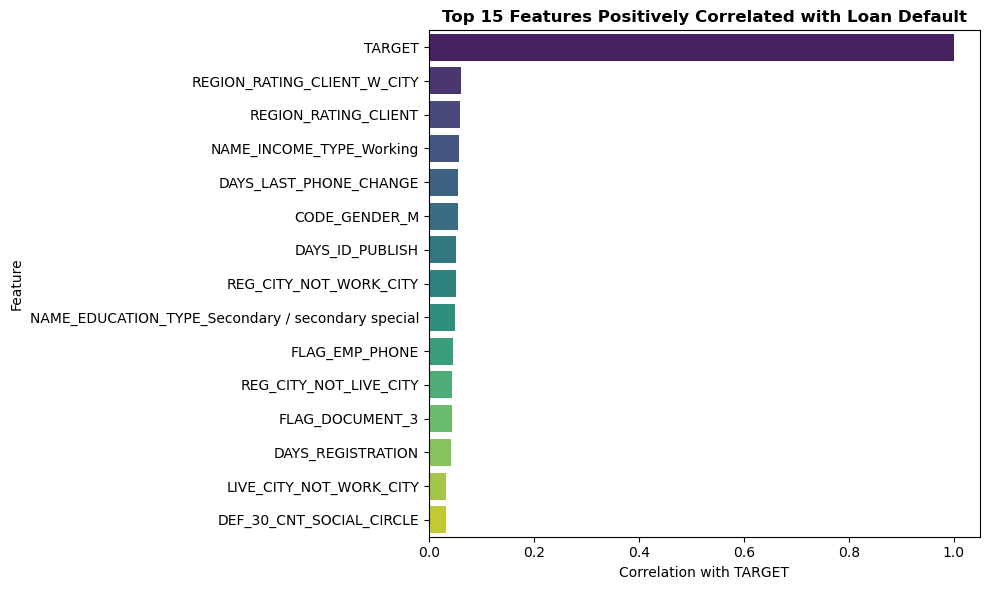


Top 10 features negatively correlated with default:
REGION_POPULATION_RELATIVE             -0.037227
AMT_GOODS_PRICE                        -0.039623
DAYS_EMPLOYED                          -0.044932
ORGANIZATION_TYPE_XNA                  -0.045987
NAME_INCOME_TYPE_Pensioner             -0.046209
EMPLOYMENT_YEARS                       -0.047046
NAME_EDUCATION_TYPE_Higher education   -0.056593
AGE_YEARS                              -0.078239
EXT_SOURCE_3                           -0.155892
EXT_SOURCE_2                           -0.160295
Name: TARGET, dtype: float64

Top 20 Selected Features (ANOVA F-test):
                                               Feature        Score
29                                        EXT_SOURCE_2  8109.633923
30                                        EXT_SOURCE_3  7659.288339
174                                          AGE_YEARS  1893.976087
21                         REGION_RATING_CLIENT_W_CITY  1144.461405
20                                REGION_RATIN

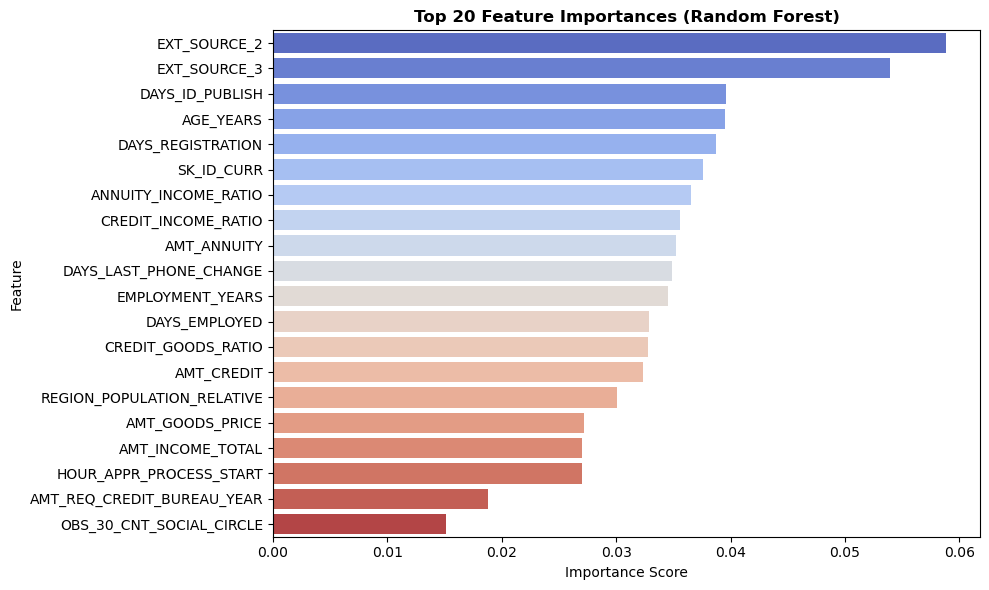


Reduced dataset shape: (307511, 33)


/var/folders/42/y0z8syd96cl0ylsq6437shmw0000gn/T/ipykernel_35627/2039924425.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reduced[selected_features] = scaler.fit_transform(data_reduced[selected_features])



Feature-engineered dataset saved successfully at: data/featured_application_train.csv


In [2]:
# 🧠 Project 1: Feature Engineering & Selection
# CSCD613 - Machine Learning with Big Data Analytics (Group 10)
# -------------------------------------------------------------
# Objective:
#   Enhance the predictive power of the dataset through the creation,
#   transformation, and selection of relevant features.
#
# Main Tasks:
#   1. Load the cleaned dataset
#   2. Create new derived features (ratios and domain-based features)
#   3. Analyze feature correlations
#   4. Identify and select important features for modeling
#   5. Save the transformed dataset

# -------------------------------------------------------------
# Step 1: Import Libraries
# -------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Display settings
pd.set_option('display.max_columns', 100)

# -------------------------------------------------------------
# Step 2: Load Cleaned Dataset
# -------------------------------------------------------------

data = pd.read_csv('data/cleaned_application_train.csv')
print("Dataset shape:", data.shape)
data.head()

# -------------------------------------------------------------
# Step 3: Create Derived Features
# -------------------------------------------------------------
# Feature engineering is about combining or transforming raw data
# into meaningful predictors that help the model learn patterns.

# Check if required columns exist before feature creation
required_cols = ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH']
for col in required_cols:
    if col not in data.columns:
        print(f"Warning: Column '{col}' not found in dataset.")

# Credit-to-Income ratio
if all(col in data.columns for col in ['AMT_CREDIT', 'AMT_INCOME_TOTAL']):
    data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 1)

# Annuity-to-Income ratio
if all(col in data.columns for col in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL']):
    data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 1)

# Credit-to-Goods ratio
if all(col in data.columns for col in ['AMT_CREDIT', 'AMT_GOODS_PRICE']):
    data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 1)

# Applicant's Age (convert from DAYS_BIRTH)
if 'DAYS_BIRTH' in data.columns:
    data['AGE_YEARS'] = abs(data['DAYS_BIRTH']) / 365
    data.drop(columns=['DAYS_BIRTH'], inplace=True)

# Employment stability (if available)
if 'DAYS_EMPLOYED' in data.columns:
    data['EMPLOYMENT_YEARS'] = abs(data['DAYS_EMPLOYED']) / 365

# Display new columns
print("\nNew derived features added:")
print([col for col in data.columns if 'RATIO' in col or 'AGE' in col or 'EMPLOYMENT' in col])

# -------------------------------------------------------------
# Step 4: Feature Correlation Analysis
# -------------------------------------------------------------
# Understanding relationships between features and the target variable

plt.figure(figsize=(10, 6))
corr = data.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)
sns.barplot(x=corr[:15].values, y=corr[:15].index, hue=corr[:15].index, palette='viridis', legend=False)
plt.title("Top 15 Features Positively Correlated with Loan Default", fontsize=12, fontweight='bold')
plt.xlabel("Correlation with TARGET")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: view top negative correlations as well
print("\nTop 10 features negatively correlated with default:")
print(corr.tail(10))

# -------------------------------------------------------------
# Step 5: Feature Selection using Statistical Test (ANOVA)
# -------------------------------------------------------------
# This helps identify which numerical features are most predictive.

# Separate features and target
X = data.drop(columns=['TARGET'])
y = data['TARGET']

# Apply SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X, y)
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
top_features = scores.sort_values(by='Score', ascending=False).head(20)
print("\nTop 20 Selected Features (ANOVA F-test):")
print(top_features)

# -------------------------------------------------------------
# Step 6: Feature Importance using Random Forest
# -------------------------------------------------------------
# Tree-based models naturally compute feature importance.

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importances, palette='coolwarm', legend=False)
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=12, fontweight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# Step 7: Reduce Dataset to Top Features (Optional)
# -------------------------------------------------------------

# Combine top features from both methods
selected_features = list(set(top_features['Feature']).union(set(importances['Feature'])))
data_reduced = data[selected_features + ['TARGET']]

print("\nReduced dataset shape:", data_reduced.shape)

# -------------------------------------------------------------
# Step 8: Normalize Key Features (Optional)
# -------------------------------------------------------------

scaler = MinMaxScaler()
data_reduced[selected_features] = scaler.fit_transform(data_reduced[selected_features])

# -------------------------------------------------------------
# Step 9: Save Transformed Dataset
# -------------------------------------------------------------

data_reduced.to_csv('data/featured_application_train.csv', index=False)
print("\nFeature-engineered dataset saved successfully at: data/featured_application_train.csv")

# -------------------------------------------------------------
# Summary:
# -------------------------------------------------------------
# - Created new domain-specific features
# - Analyzed feature correlations
# - Selected important variables using statistical and tree-based methods
# - Scaled features and saved dataset for modeling
#
# Next notebook → project1_03_model_training.ipynb
